In [1]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
 
import os
import random
import shutil
print(f"torch version : {torch.__version__}")

torch version : 2.0.0


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

### Data Pre-Division

If there is oversampling_data file and inside, `defect`, `normal`, `test`, `train` inside, jump to EfficientNet Part.

In [7]:
img_directory = 'printing/images'
txt_directory = 'printing/labels'
normal_directory = 'oversampling_data/normal'
defect_directory = 'oversampling_data/defect'

def move_images_based_on_defect(img_dir, txt_dir, normal_dir, defect_dir):
    # Ensure the target directories exist
    os.makedirs(normal_dir, exist_ok=True)
    os.makedirs(defect_dir, exist_ok=True)

    # Loop through each image file
    for img_file in os.listdir(img_dir):
        if img_file.endswith('.jpg'):  # Adjust the extension if necessary
            img_path = os.path.join(img_dir, img_file)
            txt_path = os.path.join(txt_dir, img_file.replace('.jpg', '.txt'))  # Adjust extension if needed

            # Read the text file to determine if it's defect or normal
            with open(txt_path, 'r') as f:
                text_content = f.read().strip()

            if text_content == "":
                # Move image to the 'normal' folder
                shutil.move(img_path, os.path.join(normal_dir, img_file))
                print(f"Moved {img_file} to {normal_dir}")
            else:
                # Move image to the 'defect' folder
                shutil.move(img_path, os.path.join(defect_dir, img_file))
                print(f"Moved {img_file} to {defect_dir}")

move_images_based_on_defect(img_directory, txt_directory, normal_directory, defect_directory)

Moved 20240823_101538.jpg to oversampling_data/normal
Moved 20240823_101543.jpg to oversampling_data/normal
Moved 20240823_101547.jpg to oversampling_data/normal
Moved 20240823_101610.jpg to oversampling_data/normal
Moved 20240823_101613.jpg to oversampling_data/normal
Moved 20240823_101617.jpg to oversampling_data/normal
Moved 20240823_101621.jpg to oversampling_data/normal
Moved 20240823_101624.jpg to oversampling_data/normal
Moved 20240823_101638.jpg to oversampling_data/normal
Moved 20240823_101644.jpg to oversampling_data/normal
Moved 20240823_101647.jpg to oversampling_data/normal
Moved 20240823_101651.jpg to oversampling_data/normal
Moved 20240823_101655.jpg to oversampling_data/normal
Moved 20240823_101658.jpg to oversampling_data/normal
Moved 20240823_101703.jpg to oversampling_data/normal
Moved 20240823_101705.jpg to oversampling_data/normal
Moved 20240823_101709.jpg to oversampling_data/normal
Moved 20240823_101713.jpg to oversampling_data/normal
Moved 20240823_101730.jpg to

In [3]:
image_path = "C:/junha/Personal_Notebook/oversampling_data"

In [4]:
def walk_through_dir(dir_path):
    """ Walks through dir_path returning its conents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 3 directoreis and 0 images in 'C:/junha/Personal_Notebook/oversampling_data'.
There are 2 directoreis and 0 images in 'C:/junha/Personal_Notebook/oversampling_data\test'.
There are 0 directoreis and 393 images in 'C:/junha/Personal_Notebook/oversampling_data\test\defect'.
There are 0 directoreis and 353 images in 'C:/junha/Personal_Notebook/oversampling_data\test\normal'.
There are 2 directoreis and 0 images in 'C:/junha/Personal_Notebook/oversampling_data\train'.
There are 0 directoreis and 1569 images in 'C:/junha/Personal_Notebook/oversampling_data\train\defect'.
There are 0 directoreis and 1409 images in 'C:/junha/Personal_Notebook/oversampling_data\train\normal'.
There are 2 directoreis and 0 images in 'C:/junha/Personal_Notebook/oversampling_data\z_keep_out_for_final_test'.
There are 0 directoreis and 20 images in 'C:/junha/Personal_Notebook/oversampling_data\z_keep_out_for_final_test\defect'.
There are 0 directoreis and 20 images in 'C:/junha/Personal_Notebook/oversamp

## Cut 20 / 20 images randomly from defect and normal for final training
I am selecting 20 images each for final validation. It's for checking.

In [11]:
image_path = 'C:/junha/Personal_Notebook/oversampling_data'
normal_folder = os.path.join(image_path, 'normal')
defect_folder = os.path.join(image_path, 'defect')
real_deal_folder = os.path.join(image_path, 'z_keep_out_for_final_test')

# Create destination subfolders for real_deal/normal and real_deal/defect
real_deal_normal = os.path.join(real_deal_folder, 'normal')
real_deal_defect = os.path.join(real_deal_folder, 'defect')
os.makedirs(real_deal_normal, exist_ok=True)
os.makedirs(real_deal_defect, exist_ok=True)

# Function to move random images and delete from original
def move_random_images(src_folder, dest_folder, count=20):
    images = [f for f in os.listdir(src_folder) if f.endswith(('.jpg', '.png'))]
    selected_images = random.sample(images, min(count, len(images)))

    for img_name in selected_images:
        src_path = os.path.join(src_folder, img_name)
        dest_path = os.path.join(dest_folder, img_name)

        # Move the image to the destination folder
        shutil.move(src_path, dest_path)
        print(f"Moved {img_name} to {dest_folder}")

# Move 20 images from normal and defect folders
move_random_images(normal_folder, real_deal_normal, 20)
move_random_images(defect_folder, real_deal_defect, 20)

print("Selected images have been moved to 'real_deal' and removed from the original folders.")

Moved 20240823_102108.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_101809.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_102223.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_103011.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_103045.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_102411.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_102917.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_102126.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_102407.jpg to C:/junha/Personal_Notebook/oversampling_data\keep_out_for_final_test\normal
Moved 20240823_102028.jpg to C:/junha/Personal_Notebook

### Make Augmented images for Train Normal

In [12]:
normal_folder = os.path.join(image_path, "normal")
save_dir = normal_folder

# 증강된 이미지 저장 폴더 생성
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


# 증강 변환 설정 (가우시안 노이즈 포함)
def augment_image(image):
    augmentation = transforms.Compose([
        transforms.RandomAffine(
            degrees=8,  # ±8도 회전
            translate=(0.03, 0.03),  # ±3% 범위 이동
            scale=(0.95, 1.05),  # ±5% 범위 스케일 조절
        ),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x + 0.02 * torch.randn_like(x)),  # 가우시안 노이즈 추가
        transforms.ToPILImage()
    ])
    return augmentation(image)


# 폴더 내 모든 이미지에 대해 무작위 증강 수행
for filename in os.listdir(normal_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        img_path = os.path.join(normal_folder, filename)
        original_image = Image.open(img_path)
        base_name = os.path.splitext(filename)[0]

        # 각 이미지에 대해 랜덤 증강 개수 지정 (예: 5~10 사이 랜덤 증강)
        num_augments = random.randint(5, 10)
        for i in range(num_augments):
            augmented_image = augment_image(original_image)
            save_path = os.path.join(save_dir, f"{base_name}_aug_{i + 1}.jpg")
            augmented_image.save(save_path)
            print(f"Saved augmented image: {save_path}")

print("All images have been randomly augmented and saved.")

Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_1.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_2.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_3.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_4.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_5.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_6.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101538_aug_7.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101543_aug_1.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101543_aug_2.jpg
Saved augmented image: C:/junha/Personal_Notebook/oversampling_data\normal\20240823_101543_

In [13]:
augmented_images_dir = "C:\junha\Personal_Notebook\oversampling_data"

## Split Data by 80% / 20%

In [14]:
base_dir = 'C:/junha/Personal_Notebook/oversampling_data'
train_dir = 'C:/junha/Personal_Notebook/oversampling_data/train'
test_dir = 'C:/junha/Personal_Notebook/oversampling_data/test'

# Create train and test directories
os.makedirs(os.path.join(train_dir, 'defect'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'normal'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'defect'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'normal'), exist_ok=True)


# Function to split the dataset
def split_data(source_dir, train_dir, test_dir, split_ratio=0.8):
    # Get all files in the source directory
    files = os.listdir(source_dir)
    random.shuffle(files)

    # Split the files based on the ratio
    train_size = int(len(files) * split_ratio)

    train_files = files[:train_size]
    test_files = files[train_size:]

    # Copy files to the train directory
    for file in train_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(train_dir, file))

    # Copy files to the test directory
    for file in test_files:
        shutil.copy(os.path.join(source_dir, file), os.path.join(test_dir, file))


# Split defect and normal datasets
split_data(os.path.join(base_dir, 'defect'), os.path.join(train_dir, 'defect'), os.path.join(test_dir, 'defect'))
split_data(os.path.join(base_dir, 'normal'), os.path.join(train_dir, 'normal'), os.path.join(test_dir, 'normal'))

print("Data split completed successfully.")

Data split completed successfully.


## Get Pretrained EfficientNet 

In [5]:
augmented_images_dir = "C:\junha\Personal_Notebook\oversampling_data"

In [6]:
walk_through_dir(augmented_images_dir)

There are 3 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\test'.
There are 0 directoreis and 393 images in 'C:\junha\Personal_Notebook\oversampling_data\test\defect'.
There are 0 directoreis and 353 images in 'C:\junha\Personal_Notebook\oversampling_data\test\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\train'.
There are 0 directoreis and 1569 images in 'C:\junha\Personal_Notebook\oversampling_data\train\defect'.
There are 0 directoreis and 1409 images in 'C:\junha\Personal_Notebook\oversampling_data\train\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test'.
There are 0 directoreis and 20 images in 'C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test\defect'.
There are 0 directoreis and 20 images in 'C:\junha\Personal_Notebook\oversamp

In [7]:
oversampling_train_dir = "C:/junha/Personal_Notebook/oversampling_data/train"
oversampling_test_dir = "C:/junha/Personal_Notebook/oversampling_data/test"

In [8]:
efficientNet_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
efficientNet = torchvision.models.efficientnet_b0(weights=efficientNet_weights)
efficientNet

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [9]:
# Get the transforms used to create our pretrained weights
manual_transforms = transforms.Compose([
    transforms.Resize((2532, 824)), # normal은 2532임 defect는 2732
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
manual_transforms

Compose(
    Resize(size=(2532, 824), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [12]:
#Set up dataloaders
from pytorch_modules.pytorch_modules import data_setup
oversampling_train_dataloader, oversampling_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=oversampling_train_dir,
                                                                                                     test_dir=oversampling_test_dir,
                                                                                                     transform=manual_transforms,
                                                                                                     pin_memory=False,
                                                                                                     batch_size=16)
len(class_names)

2

In [13]:
# Get the number of batches in the test dataloader
num_test_batches = len(oversampling_test_dataloader)
print(f"Number of batches in test dataloader: {num_test_batches}")

# Or, to get the total number of samples in the test set
num_test_samples = len(oversampling_test_dataloader.dataset)
print(f"Number of samples in test dataloader: {num_test_samples}")


Number of batches in test dataloader: 47
Number of samples in test dataloader: 746


In [14]:
efficientNet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

efficientNet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [15]:
for param in efficientNet.features.parameters():
  param.requires_grad = False

In [16]:
# Print with torchinfo
from torchinfo import summary

summary(model = efficientNet,
        input_size = (1,3,2532,824), # example of [batch_size, color_channels, height, width]
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 2532, 824] [1, 2]          --              Partial
├─Sequential (features)                                      [1, 3, 2532, 824] [1, 1280, 80, 26] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 2532, 824] [1, 32, 1266, 412] --              False
│    │    └─Conv2d (0)                                       [1, 3, 2532, 824] [1, 32, 1266, 412] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 1266, 412] [1, 32, 1266, 412] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 1266, 412] [1, 32, 1266, 412] --              --
│    └─Sequential (1)                                        [1, 32, 1266, 412] [1, 16, 1266, 412] --              False
│    │    └─MBConv (0)                     

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientNet.parameters(), lr= 0.001)

In [18]:
device

'cuda'

In [19]:
torch.cuda.empty_cache()

In [20]:
from pytorch_modules.pytorch_modules import engine

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=efficientNet,
                       train_dataloader=oversampling_train_dataloader,
                       test_dataloader =oversampling_test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2649 | train_acc: 0.9164 | test_loss: 0.1596 | test_acc: 0.9500
Epoch: 2 | train_loss: 0.1559 | train_acc: 0.9479 | test_loss: 0.0994 | test_acc: 0.9553
Epoch: 3 | train_loss: 0.1235 | train_acc: 0.9582 | test_loss: 0.0832 | test_acc: 0.9593
Epoch: 4 | train_loss: 0.1077 | train_acc: 0.9639 | test_loss: 0.0594 | test_acc: 0.9707
Epoch: 5 | train_loss: 0.0869 | train_acc: 0.9729 | test_loss: 0.0445 | test_acc: 0.9827
Epoch: 6 | train_loss: 0.0827 | train_acc: 0.9729 | test_loss: 0.0499 | test_acc: 0.9840
Epoch: 7 | train_loss: 0.0709 | train_acc: 0.9803 | test_loss: 0.0457 | test_acc: 0.9814
Epoch: 8 | train_loss: 0.0696 | train_acc: 0.9803 | test_loss: 0.0301 | test_acc: 0.9854
Epoch: 9 | train_loss: 0.0547 | train_acc: 0.9823 | test_loss: 0.0220 | test_acc: 0.9973
Epoch: 10 | train_loss: 0.0554 | train_acc: 0.9883 | test_loss: 0.0196 | test_acc: 0.9960
[INFO] Total training time:  1990.580 seconds


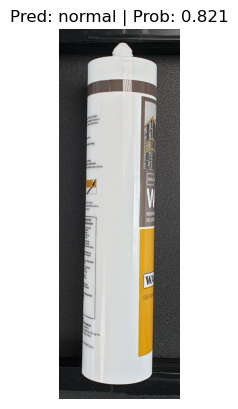

In [21]:
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image
input_image = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal/20240823_101759.jpg"

pred_and_plot_image(model=efficientNet,
                           image_path=input_image,
                           class_names=class_names,
                            transform=manual_transforms)

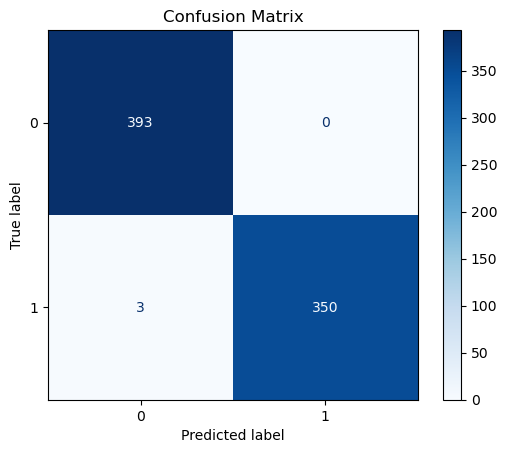

In [22]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Ensure the model is in evaluation mode
efficientNet.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Move model to the appropriate device (e.g., CPU or GPU)
efficientNet.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = efficientNet(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


F1 Score (Micro): 0.9959785522788204
F1 Score (Macro): 0.9959651466555609
Total true labels collected: 746
Total predicted labels collected: 746
True Labels: [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1

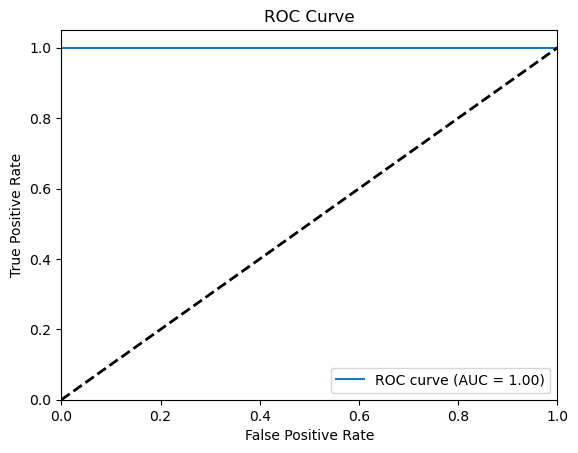

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc
import numpy as np

# Ensure the model is in evaluation mode and move it to the appropriate device
efficientNet.to(device)
efficientNet.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []
all_probabilities = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = efficientNet(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions, true labels, and predicted probabilities
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate F1 score (micro and macro)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

# Check if the task is binary classification
if len(np.unique(true_labels)) == 2:
    # Binary classification: Use only one ROC curve
    probabilities_class_1 = np.array(all_probabilities)[:, 1]
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities_class_1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Print total count of true and predicted labels for debugging
print(f"Total true labels collected: {len(true_labels)}")
print(f"Total predicted labels collected: {len(predicted_labels)}")
print(f"True Labels: {true_labels}")
print(f"Predicted Labels: {predicted_labels}")


# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [27]:
from pytorch_modules.pytorch_modules import utils

utils.save_model(model=efficientNet,
                 target_dir="C:/junha/Personal_Notebook/models",
                 model_name="efficientNet_OverSampling.pth")

[INFO] Saving model to: C:\junha\Personal_Notebook\models\efficientNet_OverSampling.pth


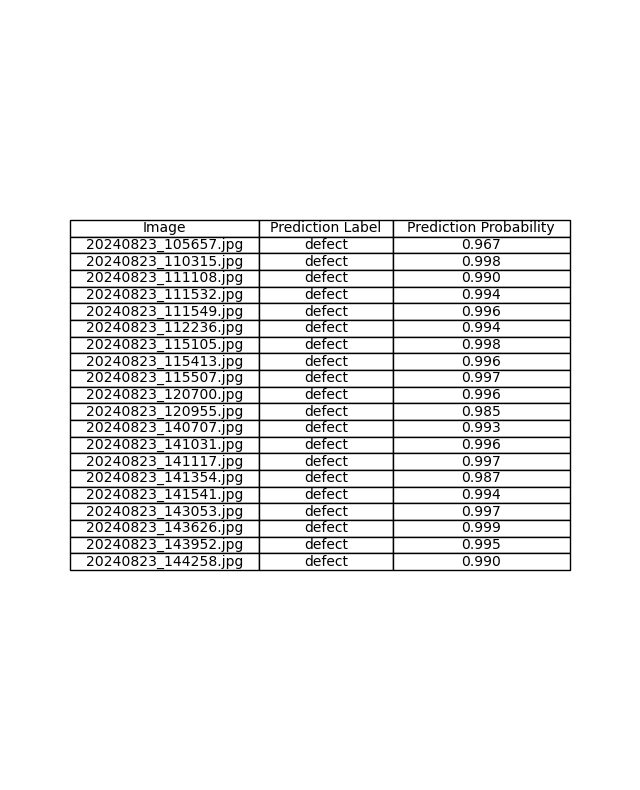

In [24]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image

# Define the path to the defect images
defect_folder = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/defect"

# Initialize a list to store predictions
results = []

# Iterate over each image in the defect folder
for image_name in os.listdir(defect_folder):
    image_path = os.path.join(defect_folder, image_name)
    
    # Call pred_and_plot_image (predictions will be shown on the plot)
    pred_and_plot_image(model=efficientNet, image_path=image_path, class_names=class_names, transform=manual_transforms)
    
    # After displaying, collect the prediction from the plot title
    plt_title = plt.gca().get_title()  # Get the title from the plot (contains label and prob)
    
    # Parse the title to extract label and probability
    pred_label = plt_title.split('|')[0].split(': ')[1].strip()
    pred_prob = plt_title.split('|')[1].split(': ')[1].strip()
    
    # Append the parsed results
    results.append([image_name, pred_label, pred_prob])
    
    # Close the plot to avoid display overload
    plt.close()

# Convert the results into a DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=["Image", "Prediction Label", "Prediction Probability"])

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(8, len(results)*0.5))  # Adjust height based on the number of rows
ax.axis('off')  # Turn off the axis
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.show()


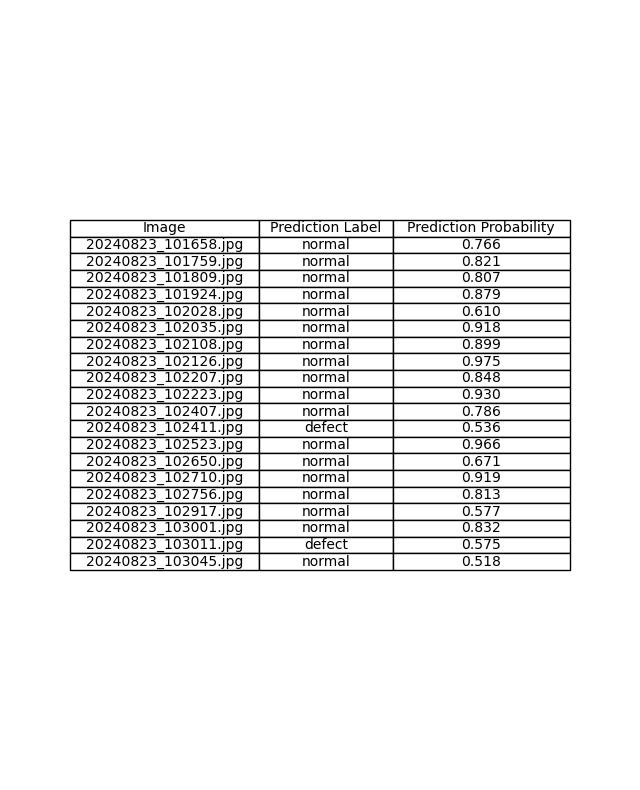

In [25]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image

# Define the path to the defect images
defect_folder = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal"

# Initialize a list to store predictions
results = []

# Iterate over each image in the defect folder
for image_name in os.listdir(defect_folder):
    image_path = os.path.join(defect_folder, image_name)
    
    # Call pred_and_plot_image (predictions will be shown on the plot)
    pred_and_plot_image(model=efficientNet, image_path=image_path, class_names=class_names, transform=manual_transforms)
    
    # After displaying, collect the prediction from the plot title
    plt_title = plt.gca().get_title()  # Get the title from the plot (contains label and prob)
    
    # Parse the title to extract label and probability
    pred_label = plt_title.split('|')[0].split(': ')[1].strip()
    pred_prob = plt_title.split('|')[1].split(': ')[1].strip()
    
    # Append the parsed results
    results.append([image_name, pred_label, pred_prob])
    
    # Close the plot to avoid display overload
    plt.close()

# Convert the results into a DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=["Image", "Prediction Label", "Prediction Probability"])

# Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(8, len(results)*0.5))  # Adjust height based on the number of rows
ax.axis('off')  # Turn off the axis
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.show()
